In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris_is_90
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11_is_90/chains???.hdf5'))
#archive_paths = sorted(glob('/local/tmp/friedrich/hat11_init/chains???.hdf5'))
print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris_is_90())
    all_times.extend(m.lc.times.jd)

#     # Convert samples into spot measurements
#     results = np.percentile(m.chains, [15.87, 50, 84.13], axis=0)

#     spots = []
#     for spot in np.split(results[:, 1:].T, (m.chains.shape[1]-1)/3):
#         ampltiude, t0, sigma = map(lambda x: Measurement(*(x[1], 
#                                                            x[2]-x[1], 
#                                                            x[1]-x[0])), 
#                                    spot)
#         spots.append(Spot(ampltiude, t0, sigma)) 
    spots = m.get_spots()
    transits.append(Transit(spots))


load results


In [4]:
from friedrich.orientation import times_to_occulted_lat_lon
from friedrich.lightcurve import hat11_params_morris_is_90

transit_params = hat11_params_morris_is_90()
all_lats = []
all_lons = []
all_amps = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
all_lats = np.array(all_lats)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

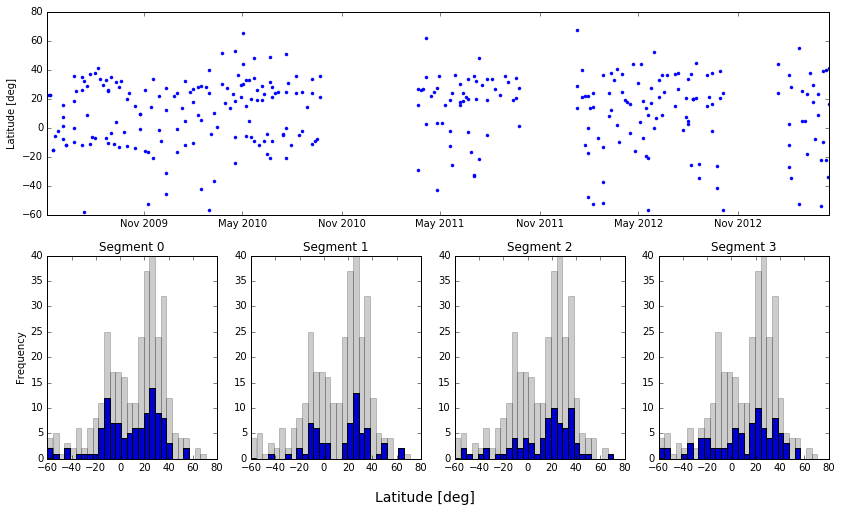

In [6]:
#all_amps
# plt.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
#               np.degrees(all_lats[all_BICs > 10]), '.')
from astropy.time import Time

n_panels = 4
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 4)
ax0 = plt.subplot(gs[0, :])
ax1 = [plt.subplot(gs[1, i]) for i in range(n_panels)]

#fig, ax = plt.subplots(1, n_panels, figsize=(14, 3))
first_spot = all_spot_times[all_BICs > 10].min()
last_spot = all_spot_times[all_BICs > 10].max()
first_to_last = last_spot - first_spot
fraction_gt_median = np.zeros(n_panels)

ax0.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
              np.degrees(all_lats[all_BICs > 10]), '.')

for i in range(n_panels):
    extent = [-60, 80]
    within_time_bin = ((all_spot_times[all_BICs > 10] - first_spot > 
                        i/n_panels*first_to_last) & 
                       (all_spot_times[all_BICs > 10] - first_spot < 
                        (i+1)/n_panels*first_to_last))
    lats_in_time_bin = np.degrees(all_lats[all_BICs > 10][within_time_bin])
    ax1[i].hist(lats_in_time_bin, 30, range=extent)

    ax1[i].hist(np.degrees(all_lats[all_BICs > 10]), 30,
                range=extent, alpha=0.2, color='k', zorder=10)

    ax1[i].set_xlim(extent)
    
    ax1[i].set(title='Segment {0}'.format(i))
    
    if i == 0:
        segment_zero_mean = np.median(lats_in_time_bin)
    fraction_gt_median[i] = np.count_nonzero(lats_in_time_bin > segment_zero_mean)/len(lats_in_time_bin)

ax1[0].set_ylabel('Frequency')
ax0.set_ylabel('Latitude [deg]')

fig.text(0.5, 0.05, 'Latitude [deg]', ha='center', fontsize=14)

#fig.subplots_adjust()

# Model

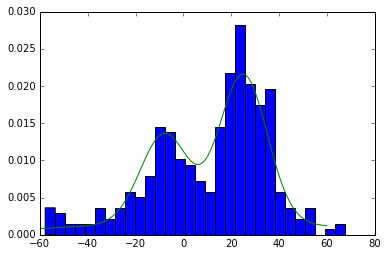

In [171]:
def gaussian(observed_latitudes, mean, std):
    return 1./np.sqrt(2*np.pi*std**2) * np.exp(-0.5 * (mean - observed_latitudes)**2 / std**2)


significant_latitudes = np.degrees(all_lats[all_BICs > 10])

def model(parameters, observed_latitudes):
    a1, m1, s1, a2, m2, s2, a3, m3, s3 = parameters
    return a1*(gaussian(observed_latitudes, m1, s1) + 
               a2 * gaussian(observed_latitudes, m2, s2) + 
               a3 * gaussian(observed_latitudes, m3, s3))


# a1, m1, s1, a2, m2, s2, a3, m3, s3
init_params = [0.5, 25, 10, 0.6, -8, 10, 0.5, 10, 60]
test_lats = np.linspace(-60, 60, 100)

plt.hist(np.degrees(all_lats[all_BICs > 10]), 30, normed=True)
plt.plot(test_lats, model(init_params, test_lats))
plt.show()

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/scipy/optimize/optimize.py:462: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= ftol):


[  0.5         25.          10.           0.60000002  -8.          10.
   0.5         10.          60.        ]


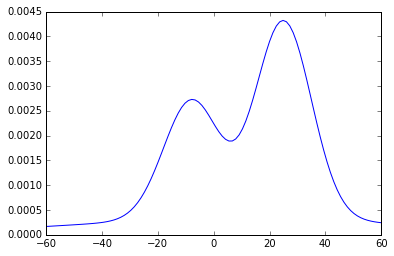

In [124]:
from scipy.optimize import fmin

bestp = fmin(lnlikelihood, np.float32(init_params), maxfun=1e4, maxiter=1e4)

print(bestp)
plt.plot(test_lats, 0.2*model(bestp, test_lats))
plt.show()

In [125]:
from scipy.integrate import quad

test_gaussian = lambda x: gaussian(x, 0, 1)
print(quad(test_gaussian, -6, 6))

(0.9999999980268247, 1.1229899055615898e-14)


In [113]:
quad(lambda x: model(bestp, x), -100, 100)

(1.024954084707494, 5.093316487591194e-09)

In [116]:
np.sum(model(init_params, significant_latitudes))

4.3816910834912228

Example:

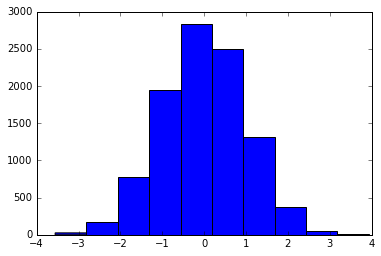

In [150]:
a = np.random.randn(10000)
plt.hist(a)
plt.show()

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log


array([  8.60642605e+04,   1.13738084e+01,   2.41701002e+01,
         2.51430713e+05,   1.19417474e+01,   2.45619639e+01,
         1.67559045e+05,   1.08496189e+01,   2.35292926e+01])

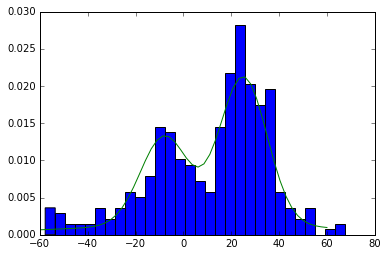

In [203]:
def gaussian(x, mean, std):
    return 1./np.sqrt(2*np.pi*std**2) * np.exp(-0.5 * (x - mean)**2 / std**2)

def lnlikelihood_gaussian(x, mean, std):
    n = float(len(x))
    return  -0.5 * np.sum((x - mean)**2) / std**2 + (-n/2) * np.log(2*np.pi*std**2)

def lnlikelihood_sum_gaussians(parameters, x):
    a1, m1, s1, a2, m2, s2, a3, m3, s3 = parameters
    parameters_sets = [[m1, s1], [m2, s2], [m3, s3]]
    return (np.sum(np.log([a1, a2, a3])) + 
            np.sum([lnlikelihood_gaussian(x, m_j, s_j) for m_j, s_j in parameters_sets]))

initp = [0.3, -8, 10, 0.5, 25, 10, 0.2, 10, 60]

def minimize_this(parameters, x):
    return -1*lnlikelihood_sum_gaussians(parameters, x)

def model(parameters, x):
    a1, m1, s1, a2, m2, s2, a3, m3, s3 = parameters
    return (a1*gaussian(x, m1, s1) + 
            a2*gaussian(x, m2, s2) + 
            a3*gaussian(x, m3, s3))

plt.hist(np.degrees(all_lats[all_BICs > 10]), 30, normed=True)
test_lats = np.linspace(-60, 60)
plt.plot(test_lats, model(initp, test_lats))


fmin(minimize_this, initp, args=(significant_latitudes, ))

initial likelihood: -75187.34903174483
[  5.45155730e-05  -2.74104721e+00   4.49332110e+00   1.03184380e-04
   9.56994643e+00   4.64631850e+00   1.62503843e+01   7.67795744e+01]
final likelihood: -14511.558696535487


/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log


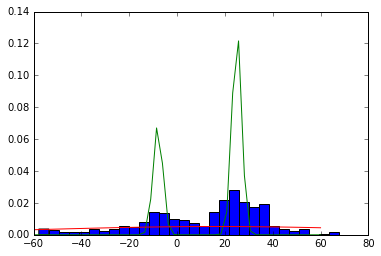

In [269]:
def gaussian(x, mean, std, amp):
    return amp/np.sqrt(2*np.pi*std**2) * np.exp(-0.5 * (x - mean)**2 / std**2)

def lnlikelihood_gaussian(x, mean, std, amp):
    n = float(len(x))
    return  -0.5 * np.sum((x - mean)**2) / std**2 + (-n/2) * np.log(2*np.pi*std**2) + np.log(amp)

def lnlikelihood_sum_gaussians(parameters, x):
    a1, m1, s1, a2, m2, s2, m3, s3 = parameters
    a3 = 1 - a1 - a2
    parameters_sets = [[a1, m1, s1], [a2, m2, s2], [a3, m3, s3]]
    return np.sum([lnlikelihood_gaussian(x, m_j, s_j, a_j) for a_j, m_j, s_j in parameters_sets])

initp = [0.35, -8, 2, 0.6499, 25, 2, 10, 60]

def minimize_this(parameters, x):
    return -1*lnlikelihood_sum_gaussians(parameters, x)

def model(parameters, x):
    a1, m1, s1, a2, m2, s2, m3, s3 = parameters
    a3 = 1 - a1 - a2
    return (gaussian(x, m1, s1, a1) + 
            gaussian(x, m2, s2, a2) + 
            gaussian(x, m3, s3, a3))

print('initial likelihood: {0}'.format(lnlikelihood_sum_gaussians(initp, significant_latitudes)))
bestp = fmin(minimize_this, initp, args=(significant_latitudes, ))
print(bestp)
print('final likelihood: {0}'.format(lnlikelihood_sum_gaussians(bestp, significant_latitudes)))

plt.hist(np.degrees(all_lats[all_BICs > 10]), 30, normed=True)
test_lats = np.linspace(-60, 60)
plt.plot(test_lats, model(initp, test_lats))
plt.plot(test_lats, model(bestp, test_lats))

In [270]:
import emcee

def lnprior(parameters):
    a1, m1, s1, a2, m2, s2, m3, s3 = parameters
    if a1 <= 1 - a2 and a2 <= 1 - a1 and 0 <= a1 <= 1 and 0 <= a2 <= 1 and s1 < 5 and s2 < 5:
        return 0.0
    return -np.inf

def lnprob(parameters, x):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood_sum_gaussians(parameters, x)

ndim, nwalkers = len(initp), 4*len(initp)
pos = [np.array(initp) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(significant_latitudes, ))
samples = sampler.run_mcmc(pos, 6000)

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


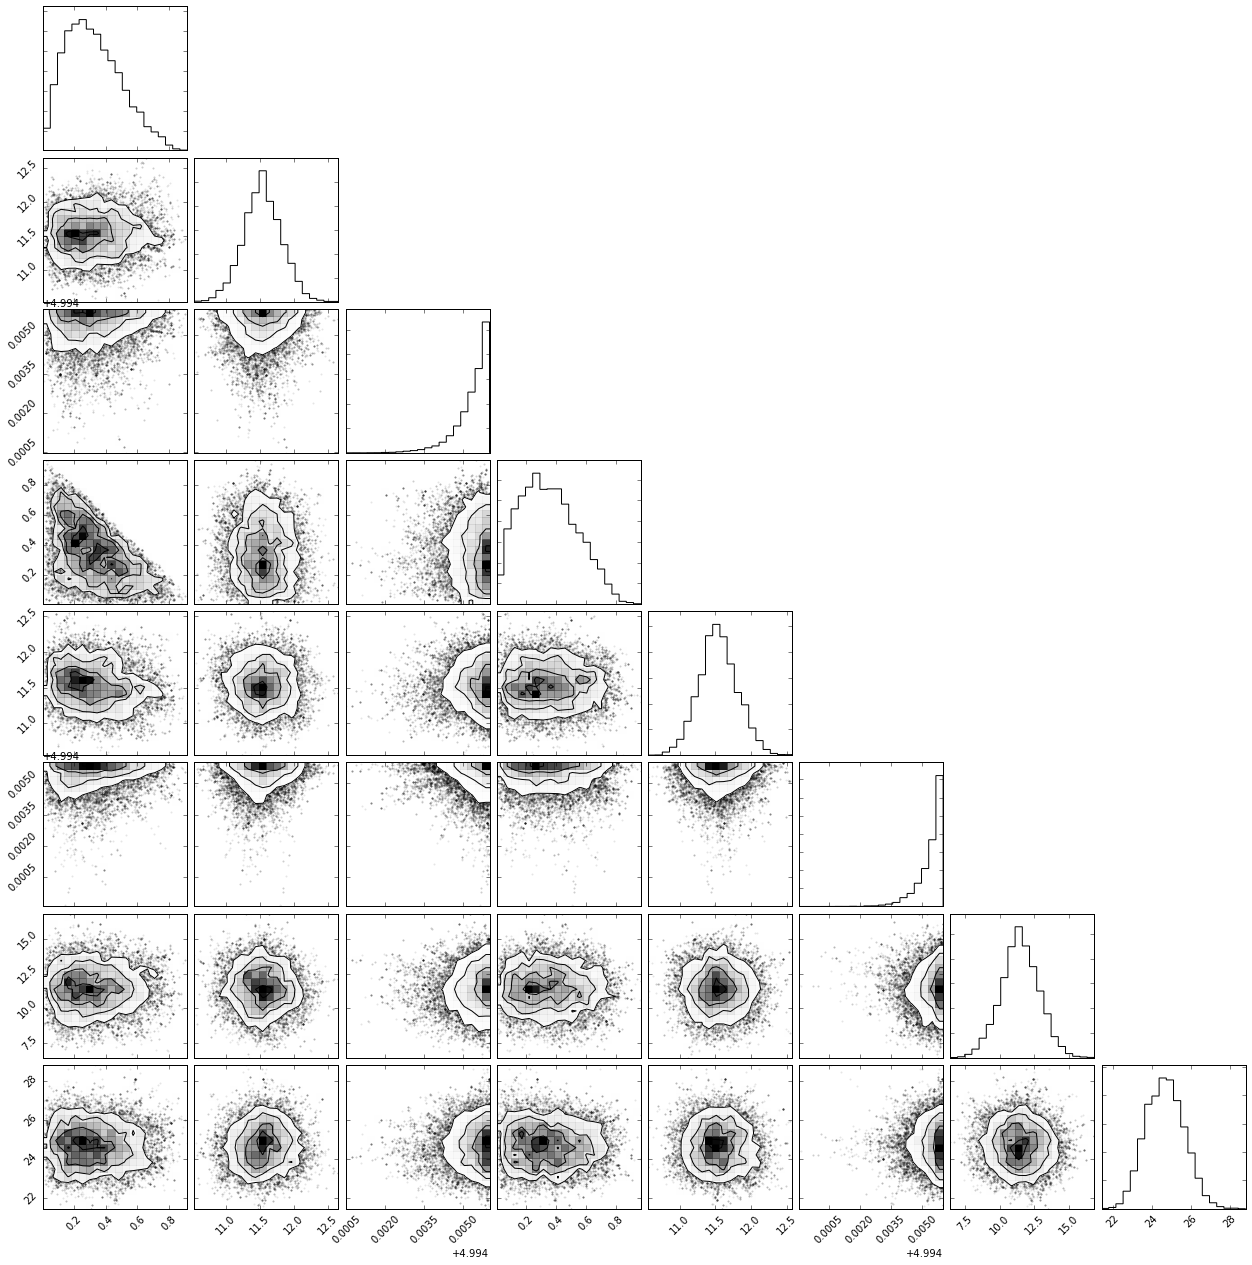

In [271]:
import corner 

burnin = 5000
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samples)

initial likelihood: -75187.34903174483
final likelihood: -11069.127327452643


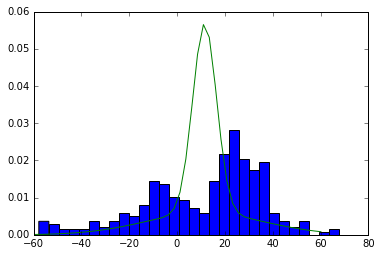

In [272]:
bestp = np.median(samples, axis=0)

plt.hist(np.degrees(all_lats[all_BICs > 10]), 30, normed=True)
test_lats = np.linspace(-60, 60)
plt.plot(test_lats, model(bestp, test_lats))

print('initial likelihood: {0}'.format(lnlikelihood_sum_gaussians(initp, significant_latitudes)))
print('final likelihood: {0}'.format(lnlikelihood_sum_gaussians(bestp, significant_latitudes)))

Two-gaussian model

In [361]:
import emcee

def gaussian(x, mean, std, amp):
    return amp/np.sqrt(2*np.pi*std**2) * np.exp(-0.5 * (x - mean)**2 / std**2)

def lnlikelihood_gaussian(x, mean, std, amp):
    n = float(len(x))
    return  -0.5 * (x - mean)**2 / std**2 + (-n/2) * np.log(2*np.pi*std**2) + np.log(amp)

def lnlikelihood_sum_gaussians(parameters, x):
    a1, m1, s1, m2, s2 = parameters
    a2 = 1 - a1
    parameters_sets = [[a1, m1, s1], [a2, m2, s2]]
    #return np.sum([lnlikelihood_gaussian(x, m_j, s_j, a_j) for a_j, m_j, s_j in parameters_sets])
    arg1 = lnlikelihood_gaussian(x, m1, s1, a1)
    arg2 = lnlikelihood_gaussian(x, m2, s2, a2)
    return np.sum(np.logaddexp(arg1, arg2))

def minimize_this(parameters, x):
    return -1*lnlikelihood_sum_gaussians(parameters, x)

def model(parameters, x):
    a1, m1, s1, m2, s2 = parameters
    a2 = 1 - a1
    return (gaussian(x, m1, s1, a1) + 
            gaussian(x, m2, s2, a2))

def lnprior(parameters):
    a1, m1, s1, m2, s2 = parameters
    if 0 <= a1 <= 1 and s1 < 20 and s2 < 20:
        return 0.0
    return -np.inf

def lnprob(parameters, x):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood_sum_gaussians(parameters, x)

initp = [0.35, -8, 8, 25, 8]

ndim, nwalkers = len(initp), 4*len(initp)
pos = [np.array(initp) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(significant_latitudes, ))
samples = sampler.run_mcmc(pos, 6000)

[  0.41396405 -12.77422212   0.93511173  28.59314326   0.56428261]
initial likelihood: -327242.7503024492
final likelihood: -115076.54035444022


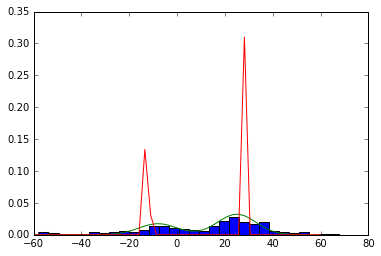

In [362]:
burnin = 5000
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

bestp = np.median(samples, axis=0)

plt.hist(np.degrees(all_lats[all_BICs > 10]), 30, normed=True)
test_lats = np.linspace(-60, 60)
plt.plot(test_lats, model(initp, test_lats))
plt.plot(test_lats, model(bestp, test_lats))
print(bestp)
print('initial likelihood: {0}'.format(lnlikelihood_sum_gaussians(initp, significant_latitudes)))
print('final likelihood: {0}'.format(lnlikelihood_sum_gaussians(bestp, significant_latitudes)))

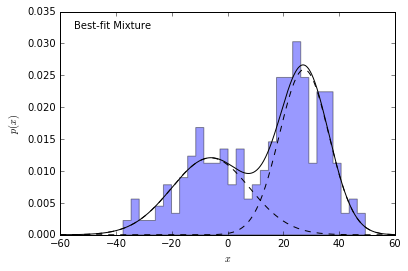

In [343]:
from sklearn.mixture import GMM

# N = np.arange(1, 11)
# models = [None for i in range(len(N))]

# for i in range(len(N)):
#     models[i] = GMM(N[i]).fit(X)

# # compute the AIC and the BIC
# AIC = [m.aic(X) for m in models]
# BIC = [m.bic(X) for m in models]

ad_hoc_cuts = (significant_latitudes > -40) * (significant_latitudes < 50)
X = np.atleast_2d(significant_latitudes[ad_hoc_cuts]).T

fig, ax = plt.subplots()
M_best = GMM(2).fit(X)#models[np.argmin(AIC)]

x = np.atleast_2d(np.linspace(-60, 60, 1000)).T
# logprob, responsibilities = M_best.eval(x)
logprob = M_best.score(x)
responsibilities = M_best.predict_proba(x)

pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

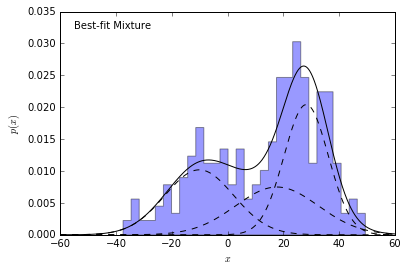

In [344]:
fig, ax = plt.subplots()
M_best = GMM(3).fit(X)#models[np.argmin(AIC)]

x = np.atleast_2d(np.linspace(-60, 60, 1000)).T
# logprob, responsibilities = M_best.eval(x)
logprob = M_best.score(x)
responsibilities = M_best.predict_proba(x)

pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')